In [1]:
!nvidia-smi

Thu Dec 30 13:06:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Downloading Dataset

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 94% 118M/126M [00:00<00:00, 131MB/s] 
100% 126M/126M [00:00<00:00, 134MB/s]


In [ ]:
!unzip *.zip && rm -rf *.zip

#Loading and Preprocessing Images

In [5]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE =32

In [6]:
TRAIN_IMAGES_PATH = "/content/Emotions Dataset/train"
TEST_IMAGES_PATH = "/content/Emotions Dataset/test"

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    shear_range = 0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_IMAGES_PATH,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="categorical",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_IMAGES_PATH,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="categorical",
    shuffle=True
)

Found 6799 images belonging to 3 classes.
Found 2278 images belonging to 3 classes.


In [13]:
classnames = train_generator.class_indices
numclasses = train_generator.num_classes
class_labels = [i for i in classnames.keys()]

In [14]:
class_labels

['angry', 'happy', 'sad']

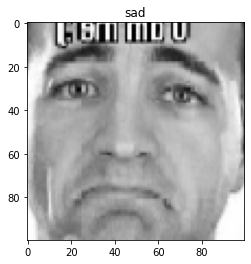

In [19]:
import random
import matplotlib.pyplot as plt

img, label = train_generator.__next__()
i = random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:, :, 0], cmap="gray")
plt.title(labl)
plt.show()

#Model Development

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [22]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(100, 100, 1)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))

model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(numclasses, activation="softmax"))

In [28]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

In [24]:
import os

num_train_images = 0
for root, dirs, files in os.walk(TRAIN_IMAGES_PATH):
  num_train_images += len(files)

num_test_images = 0
for root, dirs, files in os.walk(TEST_IMAGES_PATH):
  num_test_images += len(files)

In [29]:
EPOCHS = 50

history = model.fit(
    train_generator,
    steps_per_epoch=num_train_images//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=num_test_images//BATCH_SIZE
)

Epoch 1/50
212/212 [==============================] - 46s 162ms/step - loss: 1.0251 - accuracy: 0.4946 - val_loss: 0.9563 - val_accuracy: 0.5436
Epoch 2/50
212/212 [==============================] - 36s 172ms/step - loss: 0.9381 - accuracy: 0.5655 - val_loss: 0.8648 - val_accuracy: 0.5854
Epoch 3/50
212/212 [==============================] - 35s 165ms/step - loss: 0.8532 - accuracy: 0.6071 - val_loss: 0.7674 - val_accuracy: 0.6585
Epoch 4/50
212/212 [==============================] - 35s 163ms/step - loss: 0.7758 - accuracy: 0.6514 - val_loss: 0.7455 - val_accuracy: 0.6633
Epoch 5/50
212/212 [==============================] - 36s 170ms/step - loss: 0.7190 - accuracy: 0.6830 - val_loss: 0.6334 - val_accuracy: 0.7306
Epoch 6/50
212/212 [==============================] - 33s 157ms/step - loss: 0.6756 - accuracy: 0.7003 - val_loss: 0.6146 - val_accuracy: 0.7403
Epoch 7/50
212/212 [==============================] - 35s 163ms/step - loss: 0.6289 - accuracy: 0.7321 - val_loss: 0.5998 - val_ac

#Plots

In [32]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

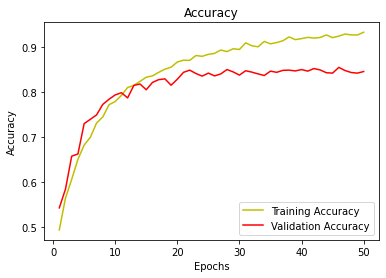

In [35]:
plt.plot(epochs, accuracy, "y", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

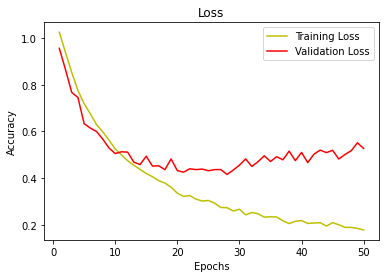

In [36]:
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Saving Model

In [37]:
model.save("emotions_detection.h5")

#Evalutaion

In [38]:
import numpy as np

test_img, test_lbl = test_generator.__next__()
predictions=model.predict(test_img)

predictions=np.argmax(predictions, axis=1)
test_labels=np.argmax(test_lbl, axis=1)

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)

In [41]:
cm

array([[10,  0,  3],
       [ 2,  6,  1],
       [ 1,  0,  9]])

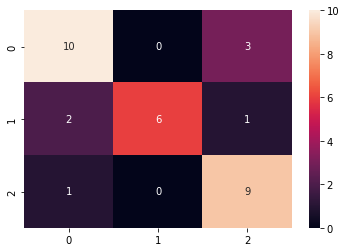

In [40]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [44]:
loss, accuracy = model.evaluate(test_generator)

72/72 [==============================] - 5s 71ms/step - loss: 0.5286 - accuracy: 0.8464


In [47]:
print("The Accuracy of Model is {}%".format(round(accuracy*100, 2)))
print("The Loss of Model is {}".format(round(loss, 2)))

The Accuracy of Model is 84.64%
The Loss of Model is 0.53


#Convert to TFlite

In [48]:
import tensorflow as tf

model =tf.keras.models.load_model("/content/emotions_detection.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("emotions_detection_tflite_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpp1_4j81h/assets


53992468

#Optmized TFLite Model

In [49]:
import tensorflow as tf

model =tf.keras.models.load_model("/content/emotions_detection.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("emotions_detection_tflite_optimized_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa_yvwu8r/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_yvwu8r/assets


13514464

#Testing Models

In [61]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [69]:
image = load_img("/content/Emotions Dataset/test/angry/147092.jpg", target_size=(100, 100), grayscale=True)
image = img_to_array(image)
image = tf.expand_dims(image, 0)
print(image.shape)

from tensorflow.keras.utils import normalize
image = normalize(image, axis=1)

(1, 100, 100, 1)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [71]:
# Using Keras Model
keras_model = tf.keras.models.load_model("/content/emotions_detection.h5", compile=False)
prediction = model.predict(image)
print(np.argmax(prediction))

0


In [72]:
# Using TFLIte without OPTIMIZE
emotion_interpreter = tf.lite.Interpreter(model_path="/content/emotions_detection_tflite_model.tflite")
emotion_interpreter.allocate_tensors()

In [73]:
# Get input and output tensors.
emotion_input_details = emotion_interpreter.get_input_details()
emotion_output_details = emotion_interpreter.get_output_details()

In [74]:
emotion_interpreter.set_tensor(emotion_input_details[0]['index'], image)
emotion_interpreter.invoke()
emotion_preds = emotion_interpreter.get_tensor(emotion_output_details[0]['index'])

In [76]:
print(np.argmax(emotion_preds))

0


In [77]:
# Using TFLIte with OPTIMIZE
emotion_interpreter = tf.lite.Interpreter(model_path="/content/emotions_detection_tflite_optimized_model.tflite")
emotion_interpreter.allocate_tensors()
# Get input and output tensors.
emotion_input_details = emotion_interpreter.get_input_details()
emotion_output_details = emotion_interpreter.get_output_details()
emotion_interpreter.set_tensor(emotion_input_details[0]['index'], image)
emotion_interpreter.invoke()
emotion_preds = emotion_interpreter.get_tensor(emotion_output_details[0]['index'])
print(np.argmax(emotion_preds))

0


In [ ]:
# All the predictions are accurate